# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

# Setup

In [23]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

In [24]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

# Random walks

### The data loader

In [71]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

In [27]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [29]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [30]:
idx

0

In [31]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [32]:
pos_rw

tensor([[2614, 1599, 2441,  ...,    9,  723,    9],
        [ 905,  389,  359,  ..., 1427,  860, 1758],
        [ 711, 2112,  711,  ...,  596, 1914,  778],
        ...,
        [2692, 1310, 2692,  ..., 1310, 2692, 1310],
        [1325, 2063, 1326,  ..., 1996, 2064, 1996],
        [ 838,  868, 1341,  ..., 2154, 1291, 1224]])

In [33]:
neg_rw

tensor([[2614, 1440, 2576,  ...,   28, 1814, 1917],
        [ 905,  413, 1185,  ..., 1965,  560, 1576],
        [ 711,  513,  727,  ..., 2031, 2118, 2195],
        ...,
        [1710, 1693,  996,  ..., 1659, 1977,  414],
        [ 120, 2312, 1755,  ..., 1517, 1321, 1006],
        [2317,  189, 2274,  ..., 2189,  496, 1084]])

### Visualization

In [34]:
import networkx as nx 
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

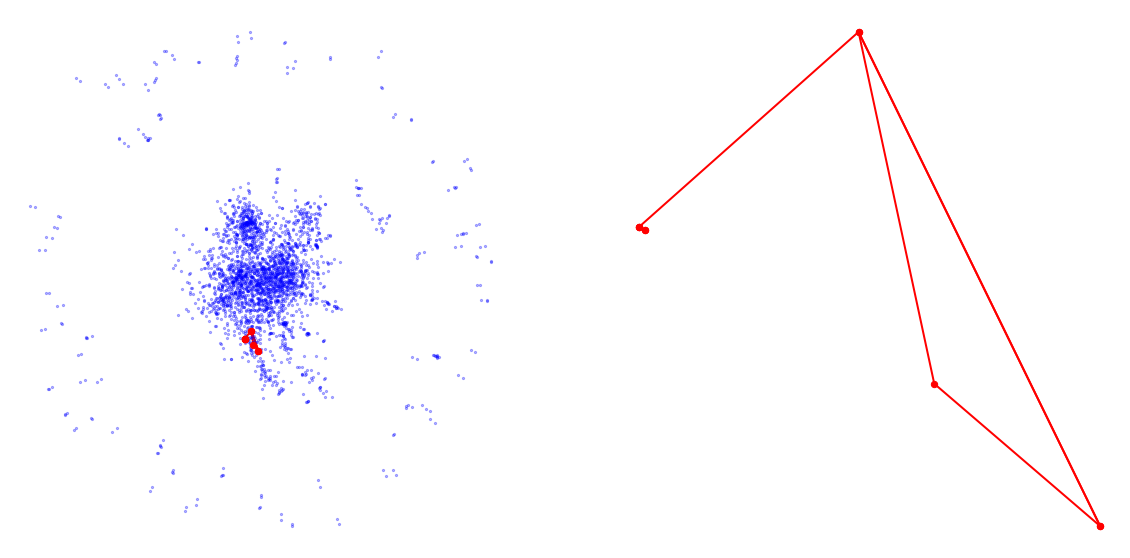

In [79]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

# Training

### Model definition

In [80]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [82]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Test function

In [83]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [84]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [85]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [86]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

### Training

In [91]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


Epoch: 01, Loss: 0.8250, Acc: 0.7120



Epoch: 02, Loss: 0.8263, Acc: 0.7120



Epoch: 03, Loss: 0.8256, Acc: 0.7080



Epoch: 04, Loss: 0.8254, Acc: 0.6990



Epoch: 05, Loss: 0.8247, Acc: 0.6910



Epoch: 06, Loss: 0.8243, Acc: 0.6990



Epoch: 07, Loss: 0.8252, Acc: 0.7070



Epoch: 08, Loss: 0.8256, Acc: 0.7150



Epoch: 09, Loss: 0.8243, Acc: 0.7070



Epoch: 10, Loss: 0.8252, Acc: 0.7030



Epoch: 11, Loss: 0.8239, Acc: 0.7070



Epoch: 12, Loss: 0.8250, Acc: 0.6990



Epoch: 13, Loss: 0.8249, Acc: 0.6970



Epoch: 14, Loss: 0.8255, Acc: 0.6990



Epoch: 15, Loss: 0.8253, Acc: 0.6960



Epoch: 16, Loss: 0.8250, Acc: 0.6990



Epoch: 17, Loss: 0.8249, Acc: 0.7070



Epoch: 18, Loss: 0.8255, Acc: 0.7100



Epoch: 19, Loss: 0.8242, Acc: 0.6950



Epoch: 20, Loss: 0.8246, Acc: 0.6960



Epoch: 21, Loss: 0.8248, Acc: 0.7100



Epoch: 22, Loss: 0.8243, Acc: 0.7120



Epoch: 23, Loss: 0.8231, Acc: 0.7150



Epoch: 24, Loss: 0.8252, Acc: 0.7180



Epoch: 25, Loss: 0.8245, Acc: 0.7220



Epoch: 26, Loss: 0.8252, Acc: 0.7180



Epoch: 27, Loss: 0.8234, Acc: 0.7180



Epoch: 28, Loss: 0.8244, Acc: 0.7120



Epoch: 29, Loss: 0.8246, Acc: 0.7040



Epoch: 30, Loss: 0.8255, Acc: 0.7060



Epoch: 31, Loss: 0.8263, Acc: 0.7020



Epoch: 32, Loss: 0.8252, Acc: 0.7090



Epoch: 33, Loss: 0.8247, Acc: 0.7160



Epoch: 34, Loss: 0.8255, Acc: 0.7050



Epoch: 35, Loss: 0.8241, Acc: 0.7000



Epoch: 36, Loss: 0.8252, Acc: 0.7080



Epoch: 37, Loss: 0.8244, Acc: 0.7130



Epoch: 38, Loss: 0.8252, Acc: 0.7120



Epoch: 39, Loss: 0.8250, Acc: 0.7090



Epoch: 40, Loss: 0.8243, Acc: 0.7100



Epoch: 41, Loss: 0.8253, Acc: 0.7250



Epoch: 42, Loss: 0.8249, Acc: 0.7240



Epoch: 43, Loss: 0.8256, Acc: 0.7160



Epoch: 44, Loss: 0.8257, Acc: 0.7040



Epoch: 45, Loss: 0.8254, Acc: 0.6900



Epoch: 46, Loss: 0.8238, Acc: 0.6850



Epoch: 47, Loss: 0.8250, Acc: 0.7020



Epoch: 48, Loss: 0.8255, Acc: 0.7050



Epoch: 49, Loss: 0.8253, Acc: 0.7010



Epoch: 50, Loss: 0.8240, Acc: 0.7000



Epoch: 51, Loss: 0.8250, Acc: 0.7030



Epoch: 52, Loss: 0.8246, Acc: 0.7040



Epoch: 53, Loss: 0.8252, Acc: 0.6920



Epoch: 54, Loss: 0.8250, Acc: 0.7040



Epoch: 55, Loss: 0.8240, Acc: 0.7010



Epoch: 56, Loss: 0.8244, Acc: 0.6920



Epoch: 57, Loss: 0.8249, Acc: 0.7080



Epoch: 58, Loss: 0.8244, Acc: 0.7120



Epoch: 59, Loss: 0.8243, Acc: 0.7080



Epoch: 60, Loss: 0.8250, Acc: 0.7010



Epoch: 61, Loss: 0.8252, Acc: 0.7020



Epoch: 62, Loss: 0.8262, Acc: 0.7130



Epoch: 63, Loss: 0.8254, Acc: 0.7140



Epoch: 64, Loss: 0.8253, Acc: 0.7180



Epoch: 65, Loss: 0.8245, Acc: 0.7160



Epoch: 66, Loss: 0.8242, Acc: 0.7130



Epoch: 67, Loss: 0.8240, Acc: 0.7020



Epoch: 68, Loss: 0.8250, Acc: 0.6970



Epoch: 69, Loss: 0.8251, Acc: 0.7130



Epoch: 70, Loss: 0.8250, Acc: 0.7180



Epoch: 71, Loss: 0.8248, Acc: 0.7150



Epoch: 72, Loss: 0.8246, Acc: 0.7230



Epoch: 73, Loss: 0.8252, Acc: 0.7080



Epoch: 74, Loss: 0.8237, Acc: 0.7200



Epoch: 75, Loss: 0.8243, Acc: 0.7080



Epoch: 76, Loss: 0.8246, Acc: 0.7070



Epoch: 77, Loss: 0.8248, Acc: 0.7000



Epoch: 78, Loss: 0.8231, Acc: 0.7000



Epoch: 79, Loss: 0.8244, Acc: 0.7010



Epoch: 80, Loss: 0.8244, Acc: 0.7040



Epoch: 81, Loss: 0.8252, Acc: 0.7110



Epoch: 82, Loss: 0.8252, Acc: 0.7090



Epoch: 83, Loss: 0.8250, Acc: 0.7160



Epoch: 84, Loss: 0.8250, Acc: 0.7170



Epoch: 85, Loss: 0.8238, Acc: 0.7180



Epoch: 86, Loss: 0.8260, Acc: 0.7260



Epoch: 87, Loss: 0.8248, Acc: 0.7240



Epoch: 88, Loss: 0.8244, Acc: 0.7340



Epoch: 89, Loss: 0.8244, Acc: 0.7250



Epoch: 90, Loss: 0.8260, Acc: 0.7190



Epoch: 91, Loss: 0.8247, Acc: 0.7170



Epoch: 92, Loss: 0.8258, Acc: 0.7210



Epoch: 93, Loss: 0.8247, Acc: 0.7200



Epoch: 94, Loss: 0.8253, Acc: 0.7220



Epoch: 95, Loss: 0.8243, Acc: 0.7210



Epoch: 96, Loss: 0.8237, Acc: 0.7170



Epoch: 97, Loss: 0.8264, Acc: 0.7190



Epoch: 98, Loss: 0.8250, Acc: 0.7160



Epoch: 99, Loss: 0.8249, Acc: 0.7160



Epoch: 100, Loss: 0.8245, Acc: 0.7120



Epoch: 101, Loss: 0.8260, Acc: 0.7190



Epoch: 102, Loss: 0.8245, Acc: 0.7240



Epoch: 103, Loss: 0.8260, Acc: 0.7300



Epoch: 104, Loss: 0.8250, Acc: 0.7120



Epoch: 105, Loss: 0.8249, Acc: 0.7110



Epoch: 106, Loss: 0.8244, Acc: 0.7230



Epoch: 107, Loss: 0.8246, Acc: 0.7320



Epoch: 108, Loss: 0.8249, Acc: 0.7100



Epoch: 109, Loss: 0.8249, Acc: 0.7200



Epoch: 110, Loss: 0.8241, Acc: 0.7110



Epoch: 111, Loss: 0.8258, Acc: 0.7220



Epoch: 112, Loss: 0.8245, Acc: 0.7160



Epoch: 113, Loss: 0.8247, Acc: 0.7350



Epoch: 114, Loss: 0.8239, Acc: 0.7240



Epoch: 115, Loss: 0.8249, Acc: 0.7160



Epoch: 116, Loss: 0.8250, Acc: 0.7210



Epoch: 117, Loss: 0.8249, Acc: 0.7190



Epoch: 118, Loss: 0.8246, Acc: 0.7200



Epoch: 119, Loss: 0.8250, Acc: 0.7170



Epoch: 120, Loss: 0.8232, Acc: 0.7160



Epoch: 121, Loss: 0.8251, Acc: 0.7130



Epoch: 122, Loss: 0.8248, Acc: 0.7210



Epoch: 123, Loss: 0.8255, Acc: 0.7350



Epoch: 124, Loss: 0.8259, Acc: 0.7300



Epoch: 125, Loss: 0.8255, Acc: 0.7180



Epoch: 126, Loss: 0.8246, Acc: 0.7170



Epoch: 127, Loss: 0.8256, Acc: 0.7130



Epoch: 128, Loss: 0.8260, Acc: 0.7170



Epoch: 129, Loss: 0.8247, Acc: 0.7100



Epoch: 130, Loss: 0.8239, Acc: 0.7140



Epoch: 131, Loss: 0.8244, Acc: 0.7200



Epoch: 132, Loss: 0.8252, Acc: 0.7180



Epoch: 133, Loss: 0.8247, Acc: 0.7260



Epoch: 134, Loss: 0.8254, Acc: 0.7150



Epoch: 135, Loss: 0.8254, Acc: 0.7100



Epoch: 136, Loss: 0.8244, Acc: 0.7100



Epoch: 137, Loss: 0.8247, Acc: 0.7100



Epoch: 138, Loss: 0.8254, Acc: 0.7230



Epoch: 139, Loss: 0.8248, Acc: 0.7100



Epoch: 140, Loss: 0.8242, Acc: 0.7060



Epoch: 141, Loss: 0.8260, Acc: 0.7020



Epoch: 142, Loss: 0.8245, Acc: 0.7110



Epoch: 143, Loss: 0.8238, Acc: 0.7070



Epoch: 144, Loss: 0.8247, Acc: 0.7030



Epoch: 145, Loss: 0.8259, Acc: 0.7120



Epoch: 146, Loss: 0.8239, Acc: 0.7070



Epoch: 147, Loss: 0.8246, Acc: 0.7120



Epoch: 148, Loss: 0.8242, Acc: 0.7190



Epoch: 149, Loss: 0.8239, Acc: 0.7150



Epoch: 150, Loss: 0.8268, Acc: 0.7160



Epoch: 151, Loss: 0.8244, Acc: 0.7100



Epoch: 152, Loss: 0.8259, Acc: 0.7170



Epoch: 153, Loss: 0.8248, Acc: 0.7110



Epoch: 154, Loss: 0.8253, Acc: 0.7130



Epoch: 155, Loss: 0.8240, Acc: 0.7140



Epoch: 156, Loss: 0.8247, Acc: 0.7130



Epoch: 157, Loss: 0.8250, Acc: 0.7040



Epoch: 158, Loss: 0.8251, Acc: 0.7040



Epoch: 159, Loss: 0.8248, Acc: 0.7200



Epoch: 160, Loss: 0.8238, Acc: 0.7170



Epoch: 161, Loss: 0.8249, Acc: 0.7210



Epoch: 162, Loss: 0.8252, Acc: 0.7170



Epoch: 163, Loss: 0.8250, Acc: 0.7270



Epoch: 164, Loss: 0.8255, Acc: 0.7150



Epoch: 165, Loss: 0.8256, Acc: 0.7310



Epoch: 166, Loss: 0.8250, Acc: 0.7160



Epoch: 167, Loss: 0.8261, Acc: 0.7130



Epoch: 168, Loss: 0.8248, Acc: 0.7010



Epoch: 169, Loss: 0.8256, Acc: 0.6920



Epoch: 170, Loss: 0.8240, Acc: 0.6960



Epoch: 171, Loss: 0.8247, Acc: 0.6990



Epoch: 172, Loss: 0.8242, Acc: 0.6990



Epoch: 173, Loss: 0.8251, Acc: 0.6960



Epoch: 174, Loss: 0.8255, Acc: 0.7120



Epoch: 175, Loss: 0.8240, Acc: 0.7190



Epoch: 176, Loss: 0.8246, Acc: 0.7220



Epoch: 177, Loss: 0.8262, Acc: 0.7140



Epoch: 178, Loss: 0.8252, Acc: 0.7140



Epoch: 179, Loss: 0.8251, Acc: 0.7020



Epoch: 180, Loss: 0.8242, Acc: 0.6990



Epoch: 181, Loss: 0.8251, Acc: 0.6930



Epoch: 182, Loss: 0.8255, Acc: 0.7030



Epoch: 183, Loss: 0.8246, Acc: 0.7150



Epoch: 184, Loss: 0.8250, Acc: 0.7080



Epoch: 185, Loss: 0.8247, Acc: 0.7020



Epoch: 186, Loss: 0.8250, Acc: 0.7130



Epoch: 187, Loss: 0.8256, Acc: 0.7170



Epoch: 188, Loss: 0.8250, Acc: 0.7140



Epoch: 189, Loss: 0.8241, Acc: 0.7110



Epoch: 190, Loss: 0.8265, Acc: 0.7010



Epoch: 191, Loss: 0.8244, Acc: 0.7100



Epoch: 192, Loss: 0.8248, Acc: 0.7030



Epoch: 193, Loss: 0.8257, Acc: 0.6940



Epoch: 194, Loss: 0.8245, Acc: 0.6970



Epoch: 195, Loss: 0.8248, Acc: 0.7070



Epoch: 196, Loss: 0.8247, Acc: 0.7120



Epoch: 197, Loss: 0.8250, Acc: 0.7190



Epoch: 198, Loss: 0.8257, Acc: 0.7100



Epoch: 199, Loss: 0.8252, Acc: 0.7090



Epoch: 200, Loss: 0.8241, Acc: 0.7200


### Visualization

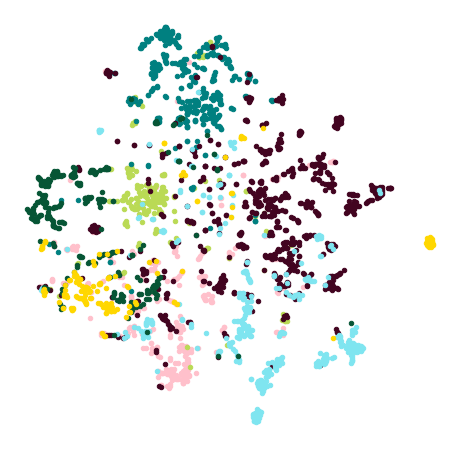

In [90]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)